# Optimising cluster shape properties with new algorithm

This algorithm uses triangles of different sizes:

1. P016
2. P03
3. P045

Together with the generator level information, we will use these three different sizes for three different studies and try to understand the impact of granularity on cluster properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import seaborn as sns
import analysis as ana
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_sample_weight
import shap
import datetime
from sklearn.datasets import make_hastie_10_2
import logging
import sys

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

### Path to the files

In [2]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU200_newalgogen_filtered.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU200_newalgocl3d_Ref_filtered.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU200_newalgocl3d_p016_filtered.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU200_newalgocl3d_p03_filtered.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PhotonPU200_newalgocl3d_p045_filtered.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogen_filtered.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_Ref_filtered.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p016_filtered.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p03_filtered.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p045_filtered.h5"

# QCD files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgogen_filtered.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_Ref_filtered.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p016_filtered.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p03_filtered.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p045_filtered.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_Ref_filtered.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p016_filtered.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p03_filtered.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p045_filtered.h5"

In [3]:
photon_df_Ref = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p016 = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf(photon_PU200_gen, photon_PU200_cl3d_p045)

In [4]:
qcd_df_Ref = ana.load_and_filter_hdf(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p016 = ana.load_and_filter_hdf(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf(qcd_PU200_gen, qcd_PU200_cl3d_p045)

In [5]:
pion_df_Ref = ana.load_and_filter_hdf(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p016 = ana.load_and_filter_hdf(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf(pion_PU200_gen, pion_PU200_cl3d_p045)

In [6]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

### Until this point, it is evident that with coarser granularity, the number of clusters increase!

In [7]:
# Delta r filter
photon_df_Ref_filtered = ana.filter_by_delta_r(photon_df_Ref, "cl3d_Ref", 0.05)
photon_df_p016_filtered = ana.filter_by_delta_r(photon_df_p016, "cl3d_p016Tri", 0.05)
photon_df_p03_filtered = ana.filter_by_delta_r(photon_df_p03, "cl3d_p03Tri", 0.05)
photon_df_p045_filtered = ana.filter_by_delta_r(photon_df_p045, "cl3d_p045Tri", 0.05)

In [8]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.1)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.1)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.1)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.1)

In [9]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.5)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.5)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.5)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.5)

## Let's begin the multi-class BDT

In [37]:
# Ref
'''photon_df_Ref_filtered['label'] = 0
pion_df_Ref_filtered['label'] = 1
qcd_df_Ref_filtered['label'] = 2
PU_df_Ref['label'] = 3'''

# p016
photon_df_p016_filtered['label'] = 0
pion_df_p016_filtered['label'] = 1
qcd_df_p016_filtered['label'] = 2
PU_df_p016['label'] = 3

# p03
'''photon_df_p03_filtered['label'] = 0
pion_df_p03_filtered['label'] = 1
qcd_df_p03_filtered['label'] = 2
PU_df_p03['label'] = 3'''

# p045
'''photon_df_p045_filtered['label'] = 0
pion_df_p045_filtered['label'] = 1
qcd_df_p045_filtered['label'] = 2
PU_df_p045['label'] = 3'''

"photon_df_p045_filtered['label'] = 0\npion_df_p045_filtered['label'] = 1\nqcd_df_p045_filtered['label'] = 2\nPU_df_p045['label'] = 3"

In [38]:
all_dfs = [qcd_df_p016_filtered, photon_df_p016_filtered, pion_df_p016_filtered, PU_df_p016]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('p016Tri') + ['label']]

In [39]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [40]:
X = df_combined[ana.columns_for_training('p016Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [41]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [42]:
model = xgb.XGBClassifier(
    objective='auc',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [43]:
model.fit(X_train, y_train, sample_weight=w_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [44]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2, 3]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")


✅ Accuracy: 0.912
🔢 Confusion Matrix:
 [[16288    67   567   289]
 [   59  1090   332    85]
 [   34    21   609    84]
 [   89    91   159  1380]]
📈 ROC AUC (OvR): 0.967


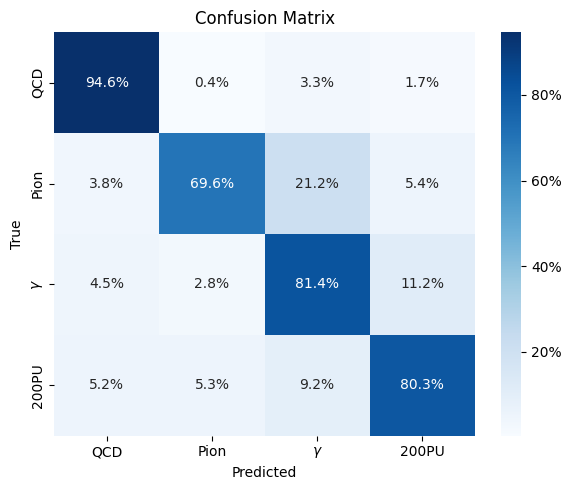

In [45]:
# Row-normalize to percentages
class_names = ['QCD', 'Pion', r'$\gamma$', '200PU']
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_pct = np.divide(conf_mat, row_sums, out=np.zeros_like(conf_mat), where=row_sums!=0) * 100.0

# Make pretty percent labels
annot_labels = np.array([[f"{v:.1f}%" for v in row] for row in conf_mat_pct])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_pct, annot=annot_labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"format": '%.0f%%'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_percent.png", dpi=300)
plt.show()

In [35]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Normalise by true class totals (row-wise)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=[0, 1, 2, 3]),
    y_pred_proba,
    multi_class='ovr'
)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("🔢 Normalised Confusion Matrix (%):\n", np.round(conf_mat_norm, 2))
print(f"📈 ROC AUC (OvR): {roc_auc*100:.2f}%")


✅ Accuracy: 93.62%
🔢 Normalised Confusion Matrix (%):
 [[95.87  1.18  2.37  0.58]
 [ 5.   73.05 19.7   2.26]
 [ 7.44  5.33 59.74 27.48]
 [ 0.94  2.66  2.43 93.97]]
📈 ROC AUC (OvR): 94.55%


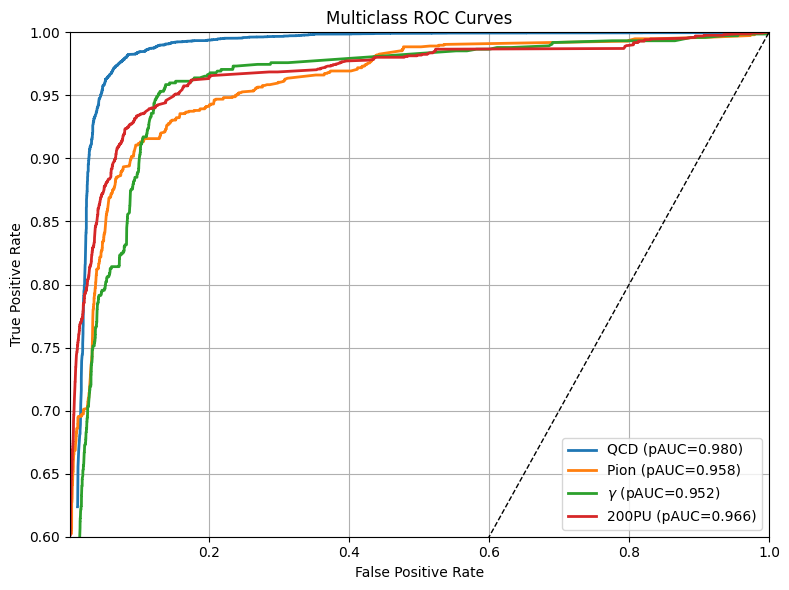

In [47]:
thr = 0.6  # signal efficiency threshold
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}
partial_auc = {}

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    # ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr_full, tpr_full)

    # Keep only points with TPR >= 0.8
    mask = tpr_full >= thr
    if np.sum(mask) > 1:
        fpr[i], tpr[i] = fpr_full[mask], tpr_full[mask]
        partial_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_names[i]} (pAUC={partial_auc[i]:.3f})")
    else:
        fpr[i], tpr[i] = None, None
        partial_auc[i] = np.nan

# Diagonal line (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.001, 1.0])
plt.ylim([thr, 1.0])  # zoom into TPR >= 0.8
#plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multiclass_roc_partial.png", dpi=300)
plt.show()

In [48]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

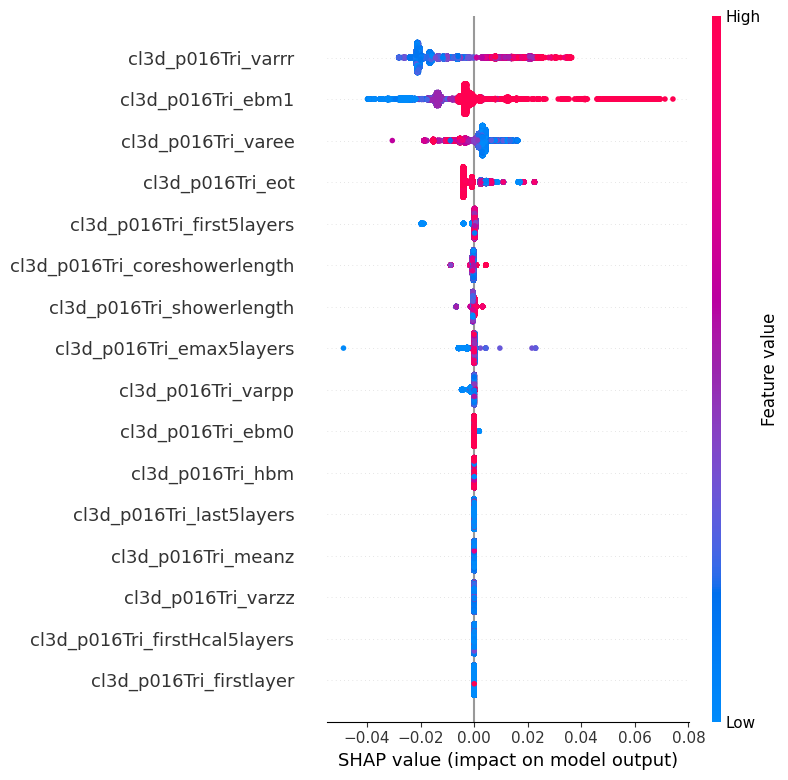

In [53]:
shap_vals_pion = shap_values[:, :, 2]
shap.summary_plot(shap_vals_pion, X_test, feature_names=ana.columns_for_training('p016Tri'), show=True)

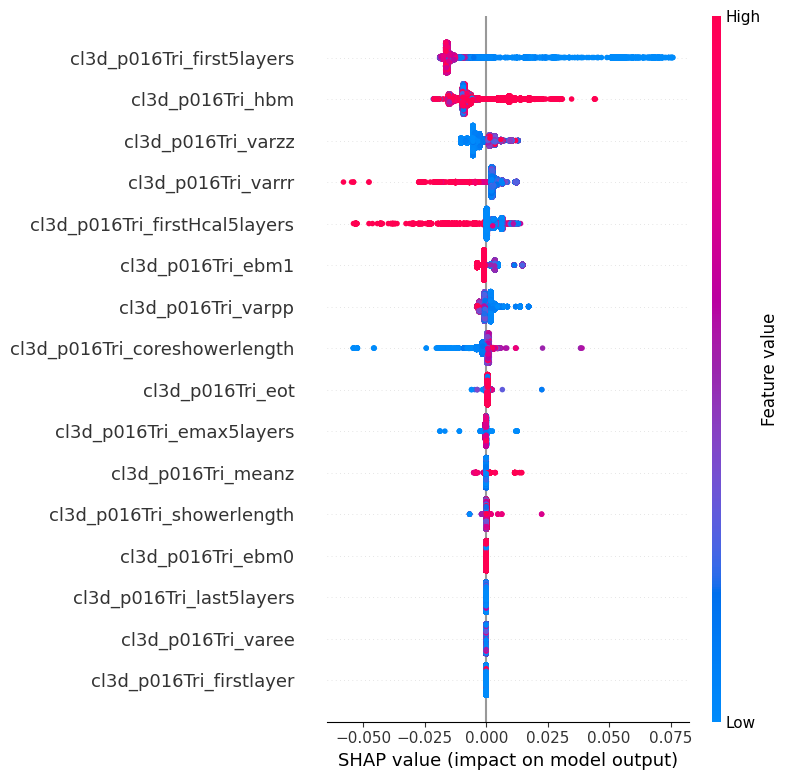

In [54]:
shap_vals_egamma = shap_values[:, :, 1]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=ana.columns_for_training('p016Tri'), show=True)

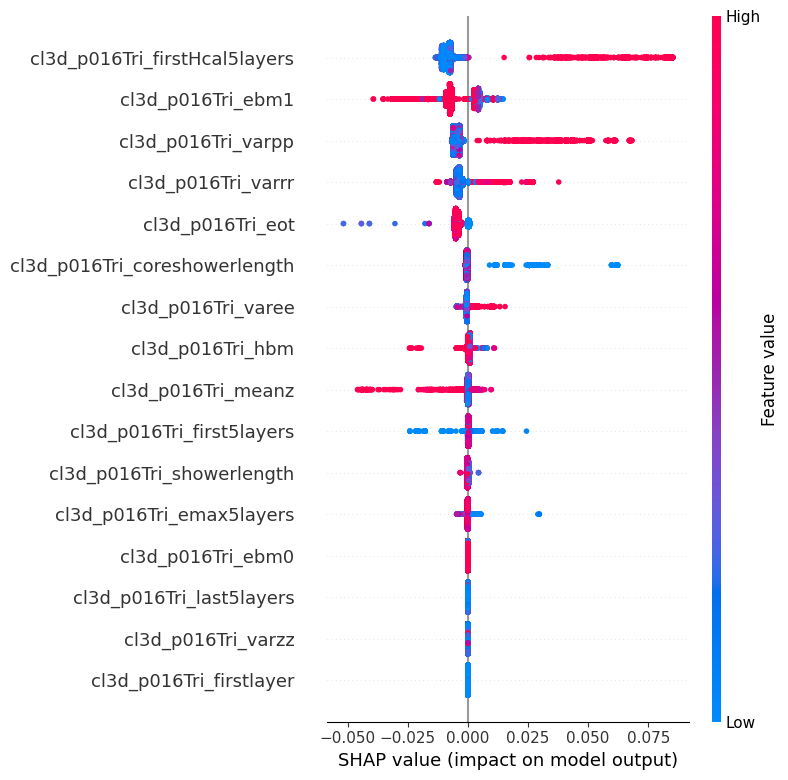

In [55]:
shap_vals_pu = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pu, X_test, feature_names=ana.columns_for_training('p016Tri'), show=True)

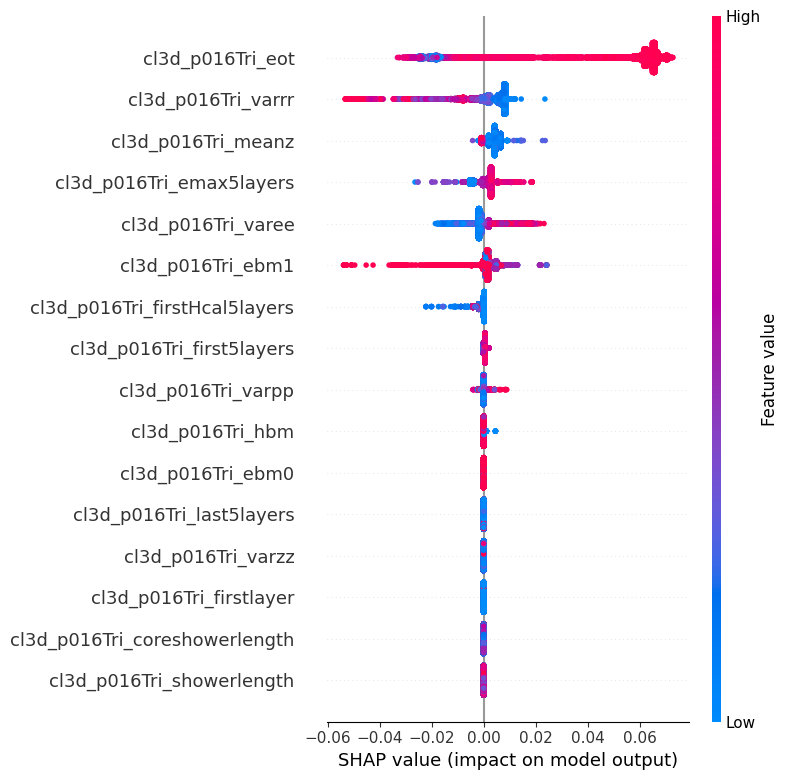

In [56]:
shap_vals_qcd = shap_values[:, :, 0]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=ana.columns_for_training('p016Tri'), show=True)

Saved: newsamples_p016_plots/cl3d_p016Tri_pt_histogram.png


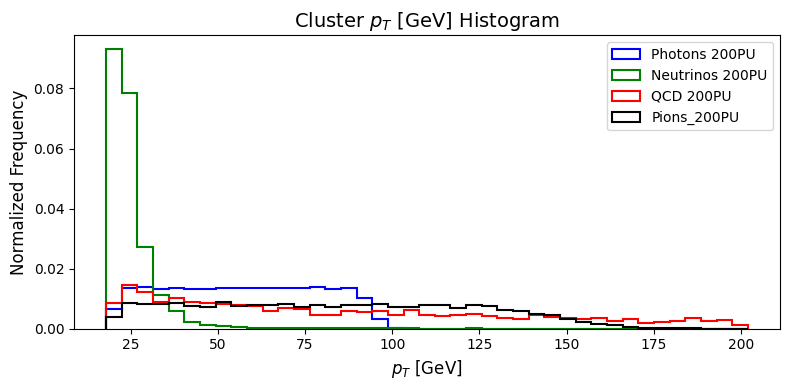

Saved: newsamples_p016_plots/cl3d_p016Tri_energy_histogram.png


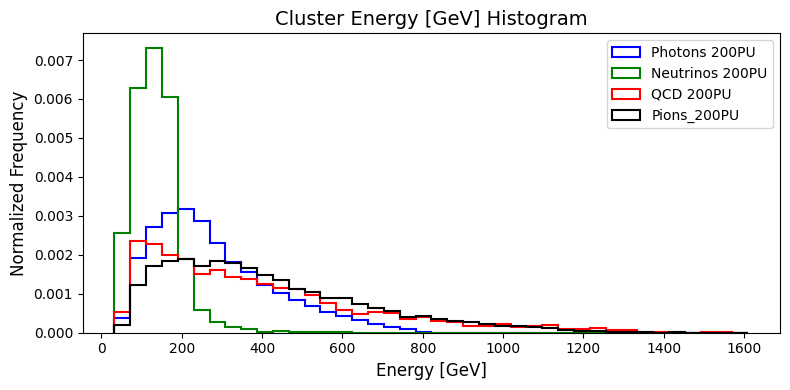

Saved: newsamples_p016_plots/cl3d_p016Tri_eta_histogram.png


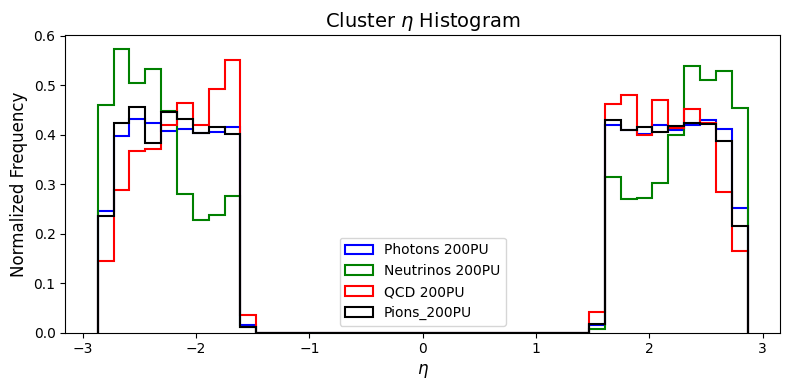

Saved: newsamples_p016_plots/cl3d_p016Tri_phi_histogram.png


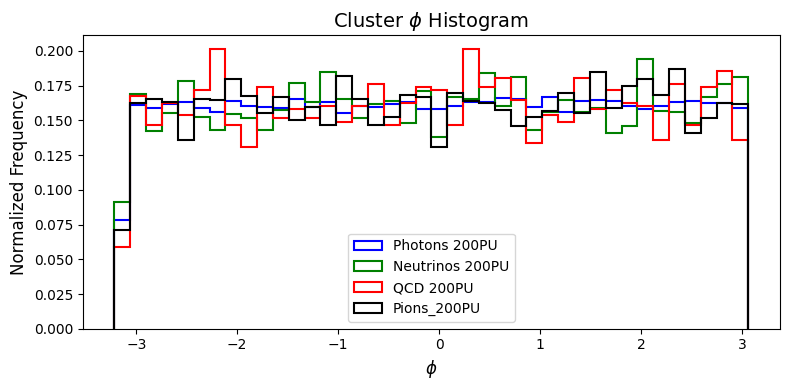

Saved: newsamples_p016_plots/cl3d_p016Tri_emax1layers_histogram.png


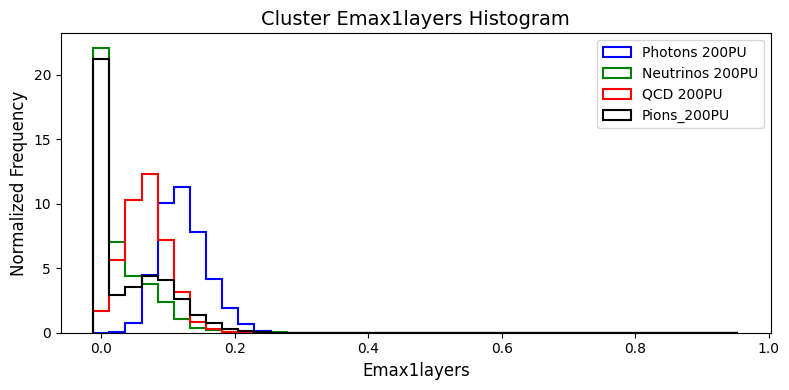

Saved: newsamples_p016_plots/cl3d_p016Tri_emax3layers_histogram.png


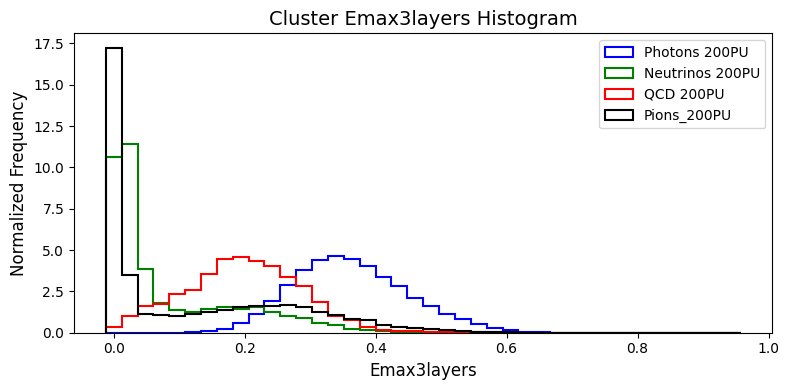

Saved: newsamples_p016_plots/cl3d_p016Tri_showerlength_histogram.png


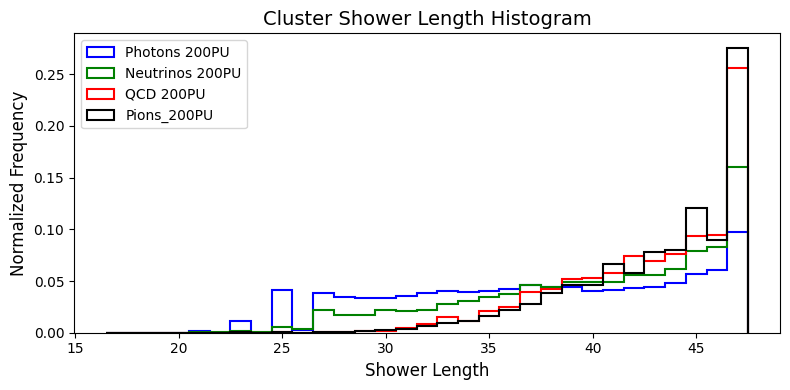

Saved: newsamples_p016_plots/cl3d_p016Tri_coreshowerlength_histogram.png


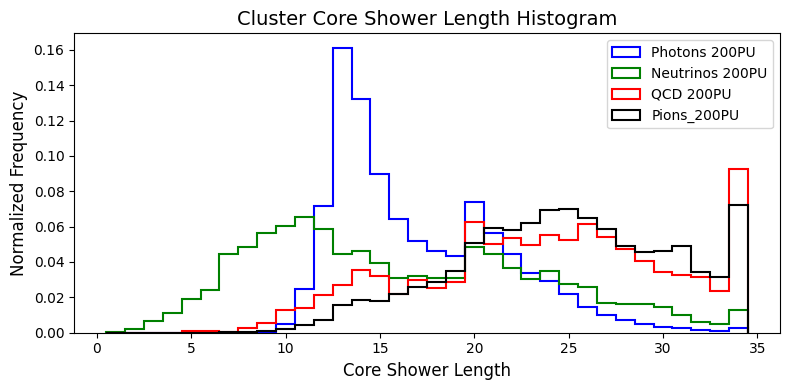

Saved: newsamples_p016_plots/cl3d_p016Tri_firstlayer_histogram.png


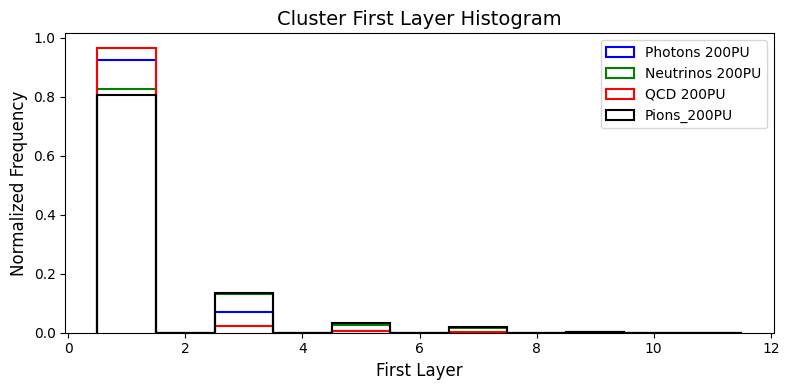

Saved: newsamples_p016_plots/cl3d_p016Tri_maxlayer_histogram.png


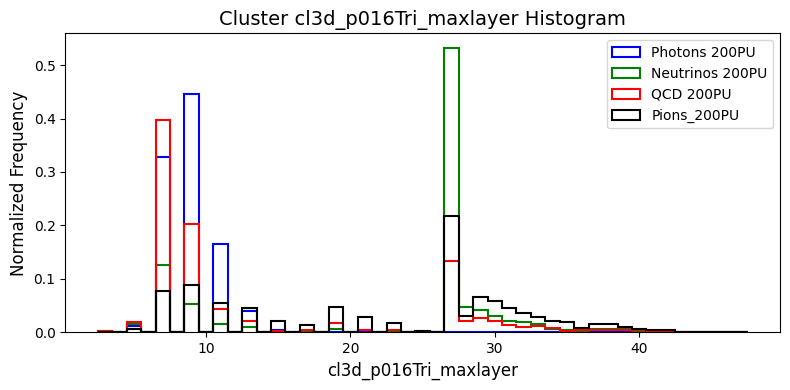

Saved: newsamples_p016_plots/cl3d_p016Tri_varrr_histogram.png


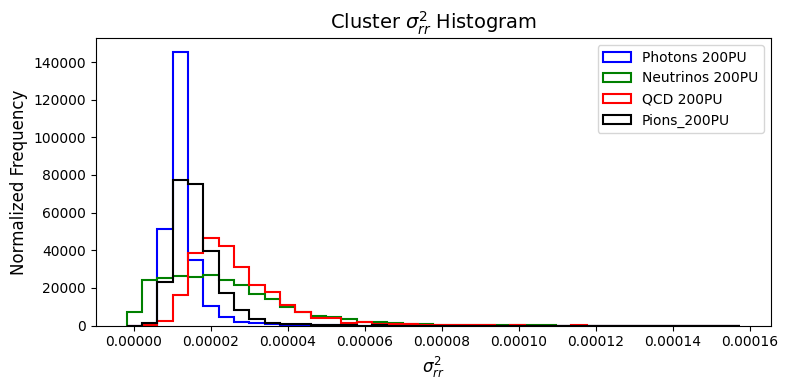

Saved: newsamples_p016_plots/cl3d_p016Tri_varzz_histogram.png


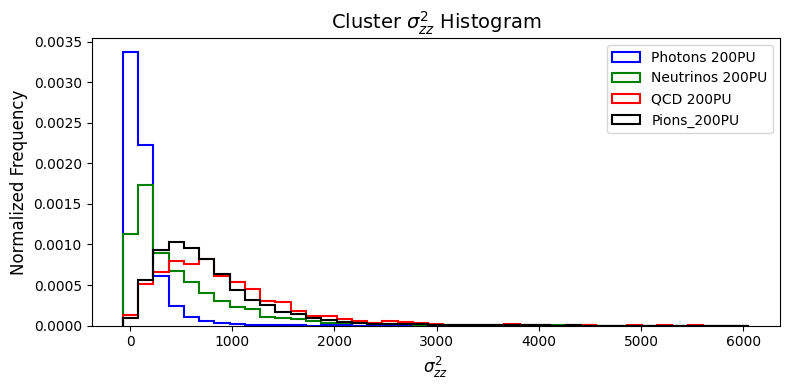

Saved: newsamples_p016_plots/cl3d_p016Tri_varee_histogram.png


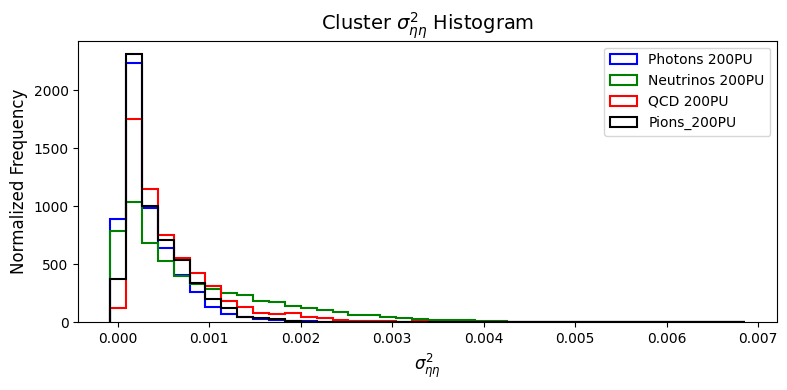

Saved: newsamples_p016_plots/cl3d_p016Tri_varpp_histogram.png


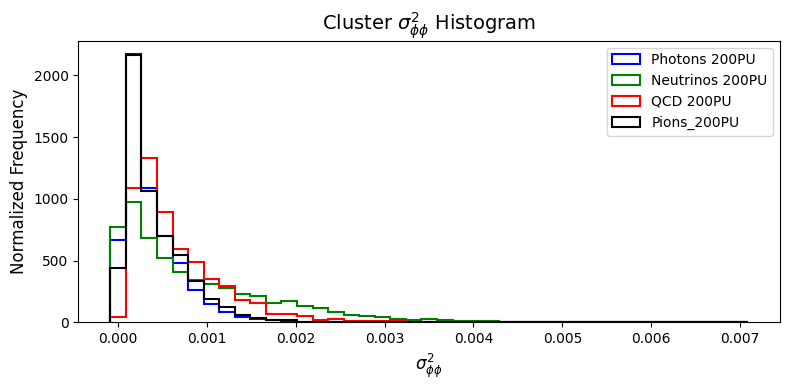

Saved: newsamples_p016_plots/cl3d_p016Tri_emaxe_histogram.png


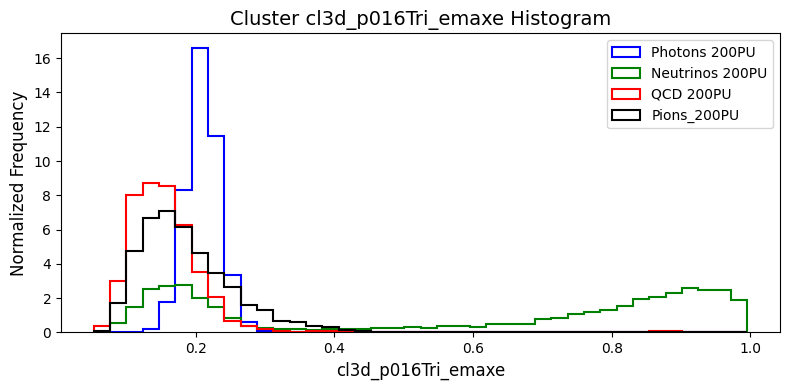

Saved: newsamples_p016_plots/cl3d_p016Tri_hoe_histogram.png


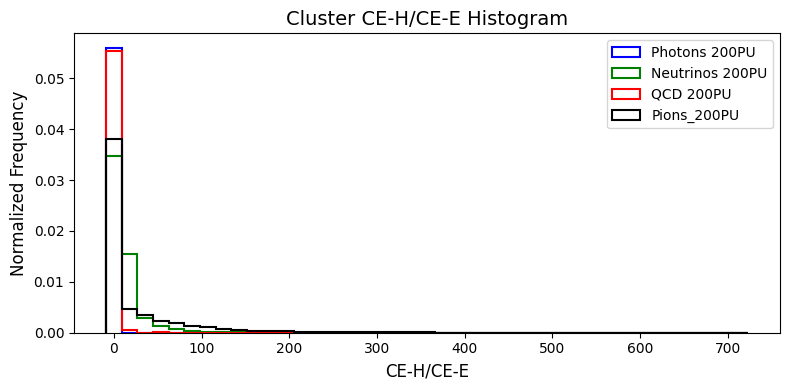

Saved: newsamples_p016_plots/cl3d_p016Tri_meanz_histogram.png


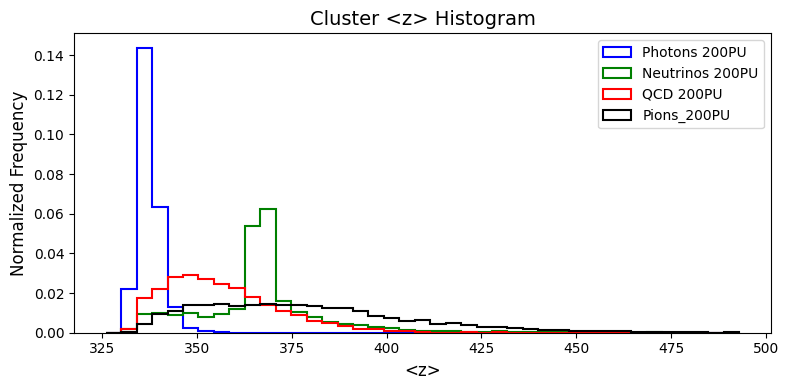

Saved: newsamples_p016_plots/cl3d_p016Tri_first1layers_histogram.png


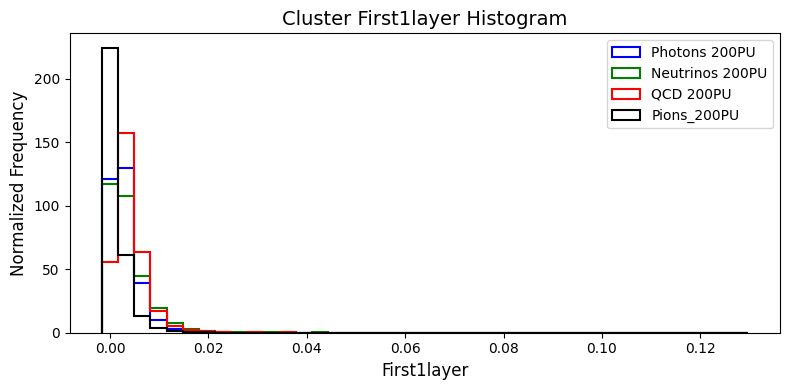

Saved: newsamples_p016_plots/cl3d_p016Tri_first3layers_histogram.png


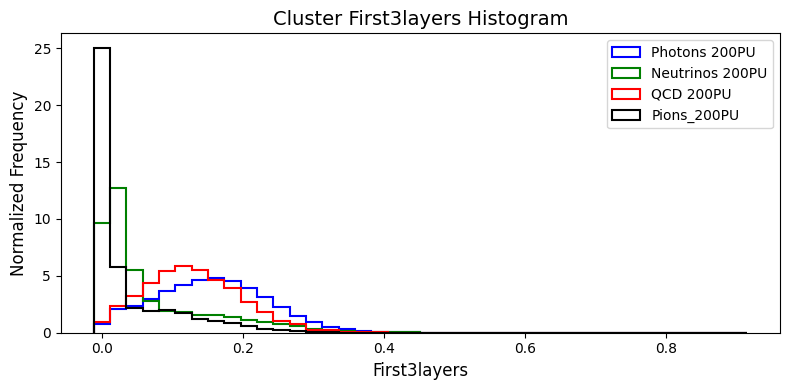

Saved: newsamples_p016_plots/cl3d_p016Tri_first5layers_histogram.png


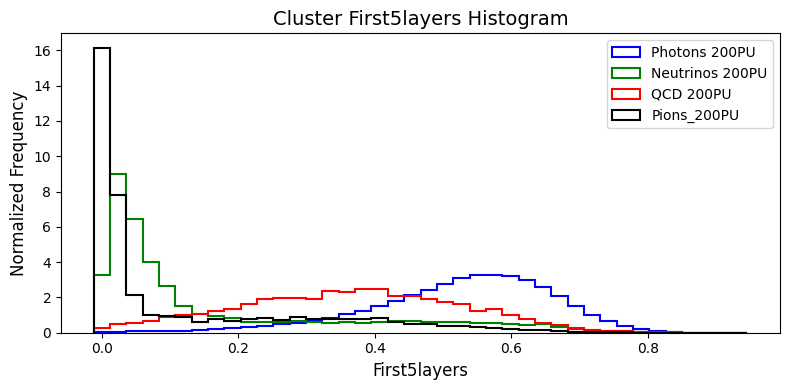

Saved: newsamples_p016_plots/cl3d_p016Tri_firstHcal1layers_histogram.png


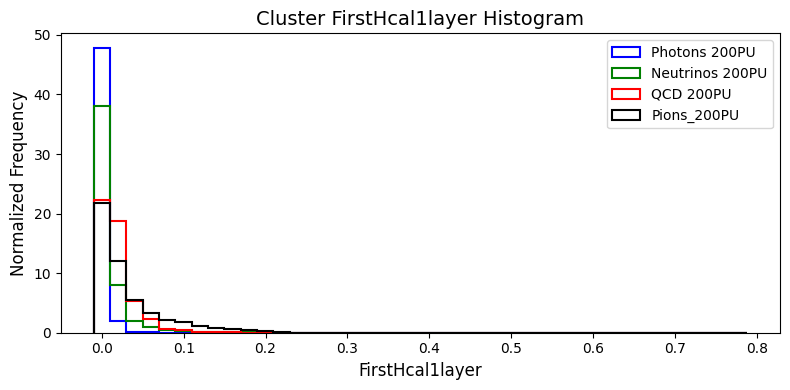

Saved: newsamples_p016_plots/cl3d_p016Tri_firstHcal3layers_histogram.png


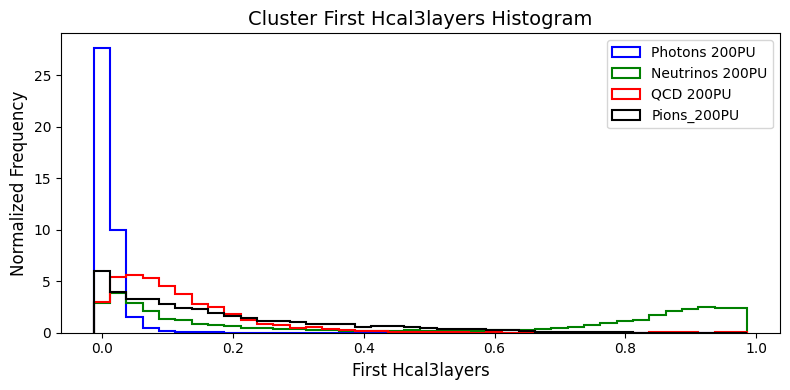

Saved: newsamples_p016_plots/cl3d_p016Tri_firstHcal5layers_histogram.png


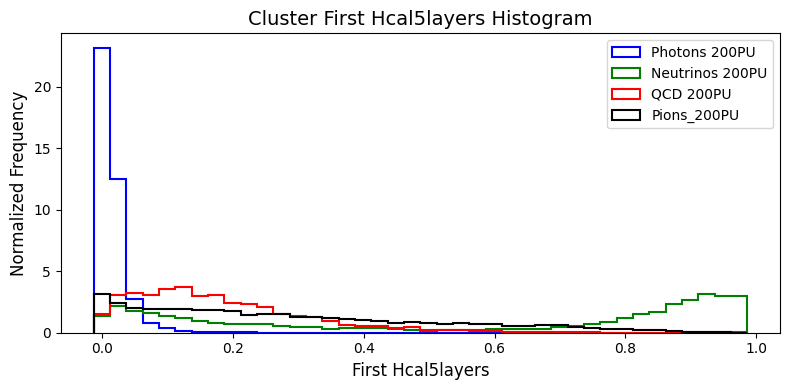

Saved: newsamples_p016_plots/cl3d_p016Tri_last1layers_histogram.png


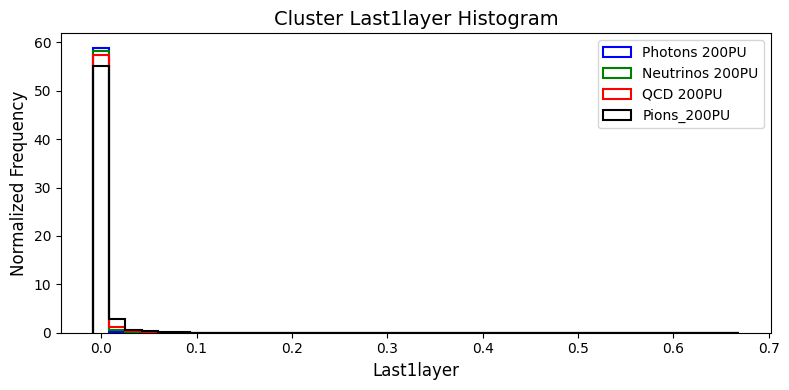

Saved: newsamples_p016_plots/cl3d_p016Tri_last3layers_histogram.png


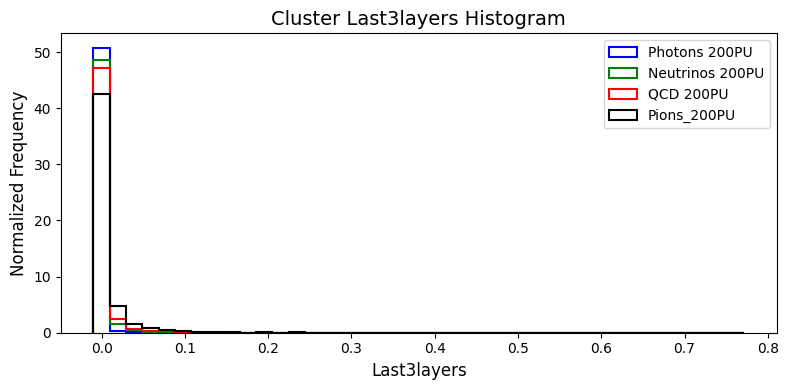

Saved: newsamples_p016_plots/cl3d_p016Tri_last5layers_histogram.png


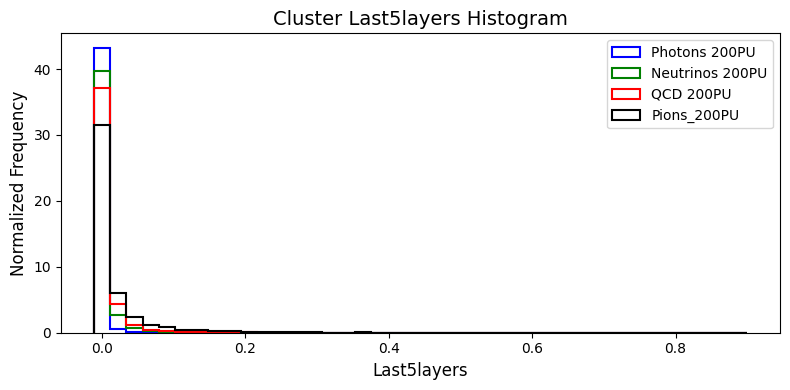

Saved: newsamples_p016_plots/cl3d_p016Tri_eot_histogram.png


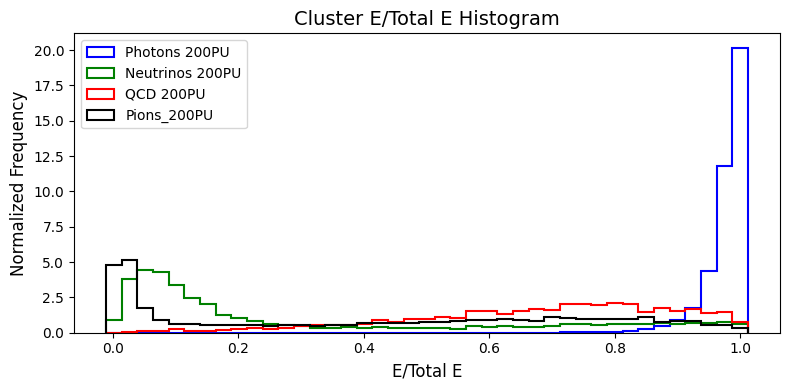

Saved: newsamples_p016_plots/cl3d_p016Tri_ebm0_histogram.png


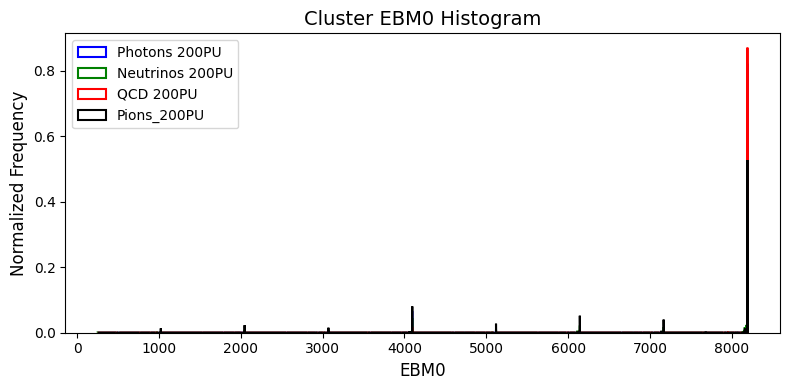

Saved: newsamples_p016_plots/cl3d_p016Tri_ebm1_histogram.png


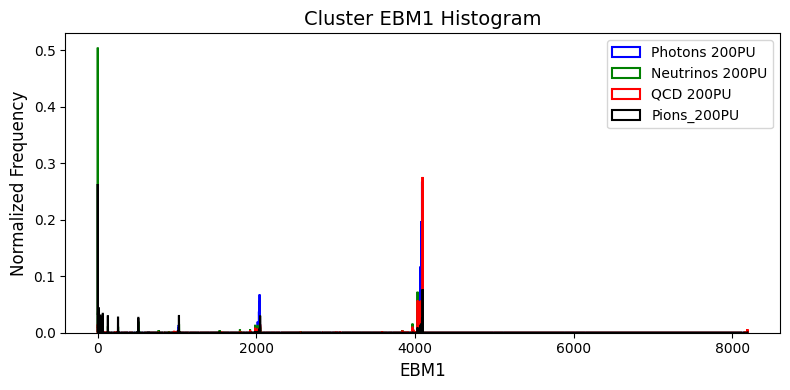

In [57]:
ana.plot_histograms(photon_df_p016_filtered, PU_df_p016, qcd_df_p016_filtered, pion_df_p016_filtered, ana.variables_to_plot('p016Tri'), 'Photons 200PU', 'Neutrinos 200PU', 'QCD 200PU', 'Pions_200PU', 'newsamples_p016_plots', ana.var_map('p016Tri'), 'p016Tri')

In [ ]:
ana.plot_histograms(photon_df_Ref_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered, ana.variables_to_plot('p03Tri'), 'Photons 200PU', 'Neutrinos 200PU', 'QCD 200PU', 'Pions_200PU', 'newsamples_p03_plots', ana.var_map('p03Tri'), 'p03Tri')plots_triangle_comparison